In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
import netCDF4 as nc
import glob
import os
import scipy as sp
from mpl_toolkits.basemap import Basemap
import pandas as pd
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri  #important!!
rpy2.robjects.numpy2ri.activate() #important!!!!
from rpy2.robjects.packages import importr
import random
import matplotlib.gridspec as gridspec

np.random.seed(7)
random.seed(7)
##this is to ensure that the results are reproducible for SOM
ss = robjects.r['set.seed']
ss(7)

koh = importr('kohonen')
r = robjects.r

In [ ]:
#counter
def count(ls,x):
    i = 0
    for j in ls:
        if j==x:
            i = i + 1
    return i

# OVERARCHING QUESTION: WHAT METEOROLOGICAL PATTERNS ARE MOST FREQUENTLY ASSOCIATED WITH SNOWMELT EVENTS OVER \
# DIFFERENT REGIONS?

# GENERAL PROCEDURE:
- I. READ IN 500 MB MAPS CORRESPONDING TO 2-DAY SNOWMELT EVENTS OVER CONUS (N=1490)
- II. PREDETERMINE NUMBER OF NODES/NEURONS/CLASSES/WEATHER PATTERNS FOR OUTPUT LAYER
- III. PERFORM SOM/KOHONEN PROCEDURE, WITH BEST MATCHING UNIT (BMU) AND NEIGHBORS MODIFIED EACH ITERATION
- IV. RESULT IS SUITE OF WEATHER MAPS WITH CHARACTERISTIC PATTERNS
- V. INPUT 500 MB MAPS CORRESPONDING TO 2-DAY SNOWMELT EVENTS OVER VARIOUS REGIONS (PNW, SIERRA NEV, ROCKIES, GREAT LAKES,NORTHEAST) AND CLASSIFY EACH MAP AS ONE OF THE CHARACTERISTIC PATTERNS I.E. THE ONE WITH MINIMUM EUCLIDEAN DISTANCE
- VI. THE CLASSIFICATION THAT CONTAINS THE LARGEST PROPORTION OF MAPS FOR EACH REGION IS THE PATTERN THAT IS MOST STRONGLY ASSOCIATED/REPRESENTATIVE OF METEOROLOGICAL CONDITIONS ASSOCIATED WITH SNOWMELT EVENTS OVER THE GIVEN REGION

In [ ]:
#read in files
#variables in file are dimension (time|1490 x lat x lon)
a = nc.Dataset("/home/weltyj/Desktop/som_test/dswe_ext_all.nc","r")
region = 'nw'
#variables in file are dimension (269 x lat x lon)
b = nc.Dataset('/home/weltyj/Desktop/som_test/dswe_ext_'+region+'.nc','r')
region = 'sierra'
#variables in file are dimension (209 x lat x lon)
c = nc.Dataset('/home/weltyj/Desktop/som_test/dswe_ext_'+region+'.nc','r')
region = 'rockies'
#variables in file are dimension (492 x lat x lon)
d = nc.Dataset('/home/weltyj/Desktop/som_test/dswe_ext_'+region+'.nc','r')
region = 'gl'
#variables in file are dimension (181 x lat x lon)
e = nc.Dataset('/home/weltyj/Desktop/som_test/dswe_ext_'+region+'.nc','r')
region = 'ne'
#variables in file are dimension (262 x lat x lon)
f = nc.Dataset('/home/weltyj/Desktop/som_test/dswe_ext_'+region+'.nc','r')

In [ ]:
#read in variables i.e. 500 mb hgt maps corresponding to melt events over CONUS, and also regionally

h500 = a.variables["h500"][:]
h500_nor = a.variables["h500nor"][:]
h500_ros = a.variables["h500ros"][:]
h500anom = a.variables["h500anom"][:]
ivt = a.variables["ivt"][:]
time = a.variables["time"][:]
ivtu = a.variables["ivtu"][:]
ivtv = a.variables["ivtv"][:]
lats = a.variables["lat"][:]
lons = a.variables["lon"][:]

h500_nw = b.variables["h500"][:]
h500_sierra = c.variables["h500"][:]
h500_rockies = d.variables["h500"][:]
h500_gl = e.variables["h500"][:]
h500_ne = f.variables["h500"][:]

h500_nw_ros = b.variables["h500ros"][:]
h500_sierra_ros = c.variables["h500ros"][:]
h500_rockies_ros = d.variables["h500ros"][:]
h500_gl_ros = e.variables["h500ros"][:]
h500_ne_ros = f.variables["h500ros"][:]

h500_nw_nor = b.variables["h500nor"][:]
h500_sierra_nor = c.variables["h500nor"][:]
h500_rockies_nor = d.variables["h500nor"][:]
h500_gl_nor = e.variables["h500nor"][:]
h500_ne_nor = f.variables["h500nor"][:]

h500anom_nw = b.variables["h500anom"][:]
h500anom_sierra = c.variables["h500anom"][:]
h500anom_rockies = d.variables["h500anom"][:]
h500anom_gl = e.variables["h500anom"][:]
h500anom_ne = f.variables["h500anom"][:]

a.close()
b.close()
c.close()
d.close()
e.close()
f.close()

In [ ]:
ab = h500[:,lats>=25.,:][:,:,lons>=-130.]
print(np.shape(ab))

(1497, 51, 105)


In [ ]:
h500shape = np.shape(h500[:,lats>=25.,:][:,:,lons>=-130.])


In [ ]:
##reshape the arrays from 3D to 2D

h500shape = np.shape(h500[:,lats>=25.,:][:,:,lons>=-130.])
ivtshape = np.shape(ivt[:,lats>=25.,:][:,:,lons>=-130.])
h500_nw_shape = np.shape(h500_nw[:,lats>=25.,:][:,:,lons>=-130.])
h500_sierra_shape = np.shape(h500_sierra[:,lats>=25.,:][:,:,lons>=-130.])
h500_rockies_shape = np.shape(h500_rockies[:,lats>=25.,:][:,:,lons>=-130.])
h500_gl_shape = np.shape(h500_gl[:,lats>=25.,:][:,:,lons>=-130.])
h500_ne_shape = np.shape(h500_ne[:,lats>=25.,:][:,:,lons>=-130.])
h500shape_ros = np.shape(h500_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500_nw_ros_shape = np.shape(h500_nw_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500_sierra_ros_shape = np.shape(h500_sierra_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500_rockies_ros_shape = np.shape(h500_rockies_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500_gl_ros_shape = np.shape(h500_gl_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500_ne_ros_shape = np.shape(h500_ne_ros[:,lats>=25.,:][:,:,lons>=-130.])
h500shape_nor = np.shape(h500_nor[:,lats>=25.,:][:,:,lons>=-130.])
h500_nw_nor_shape = np.shape(h500_nw_nor[:,lats>=25.,:][:,:,lons>=-130.])
h500_sierra_nor_shape = np.shape(h500_sierra_nor[:,lats>=25.,:][:,:,lons>=-130.])
h500_rockies_nor_shape = np.shape(h500_rockies_nor[:,lats>=25.,:][:,:,lons>=-130.])
h500_gl_nor_shape = np.shape(h500_gl_nor[:,lats>=25.,:][:,:,lons>=-130.])
h500_ne_nor_shape = np.shape(h500_ne_nor[:,lats>=25.,:][:,:,lons>=-130.])


h500reshape = np.reshape(h500[:,lats>=25.,:][:,:,lons>=-130.],(h500shape[0],h500shape[1]*h500shape[2]))
ivtreshape = np.reshape(ivt[:,lats>=25.,:][:,:,lons>=-130.],(ivtshape[0],ivtshape[1]*ivtshape[2]))
ivtureshape = np.reshape(ivtu[:,lats>=25.,:][:,:,lons>=-130.],(ivtshape[0],ivtshape[1]*ivtshape[2]))
ivtvreshape = np.reshape(ivtv[:,lats>=25.,:][:,:,lons>=-130.],(ivtshape[0],ivtshape[1]*ivtshape[2]))

h500_nw_reshape = np.reshape(h500_nw[:,lats>=25.,:][:,:,lons>=-130.],(h500_nw_shape[0],h500_nw_shape[1]*h500_nw_shape[2]))
h500_sierra_reshape = np.reshape(h500_sierra[:,lats>=25.,:][:,:,lons>=-130.],(h500_sierra_shape[0],h500_sierra_shape[1]*h500_sierra_shape[2]))
h500_rockies_reshape = np.reshape(h500_rockies[:,lats>=25.,:][:,:,lons>=-130.],(h500_rockies_shape[0],h500_rockies_shape[1]*h500_rockies_shape[2]))
h500_gl_reshape = np.reshape(h500_gl[:,lats>=25.,:][:,:,lons>=-130.],(h500_gl_shape[0],h500_gl_shape[1]*h500_gl_shape[2]))
h500_ne_reshape = np.reshape(h500_ne[:,lats>=25.,:][:,:,lons>=-130.],(h500_ne_shape[0],h500_ne_shape[1]*h500_ne_shape[2]))

h500reshape_ros = np.reshape(h500_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500shape_ros[0],h500shape_ros[1]*h500shape_ros[2]))
h500_nw_ros_reshape = np.reshape(h500_nw_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500_nw_ros_shape[0],h500_nw_ros_shape[1]*h500_nw_ros_shape[2]))
h500_sierra_ros_reshape = np.reshape(h500_sierra_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500_sierra_ros_shape[0],h500_sierra_ros_shape[1]*h500_sierra_ros_shape[2]))
h500_rockies_ros_reshape = np.reshape(h500_rockies_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500_rockies_ros_shape[0],h500_rockies_ros_shape[1]*h500_rockies_ros_shape[2]))
h500_gl_ros_reshape = np.reshape(h500_gl_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500_gl_ros_shape[0],h500_gl_ros_shape[1]*h500_gl_ros_shape[2]))
h500_ne_ros_reshape = np.reshape(h500_ne_ros[:,lats>=25.,:][:,:,lons>=-130.],(h500_ne_ros_shape[0],h500_ne_ros_shape[1]*h500_ne_ros_shape[2]))

h500reshape_nor = np.reshape(h500_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500shape_nor[0],h500shape_nor[1]*h500shape_nor[2]))
h500_nw_nor_reshape = np.reshape(h500_nw_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500_nw_nor_shape[0],h500_nw_nor_shape[1]*h500_nw_nor_shape[2]))
h500_sierra_nor_reshape = np.reshape(h500_sierra_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500_sierra_nor_shape[0],h500_sierra_nor_shape[1]*h500_sierra_nor_shape[2]))
h500_rockies_nor_reshape = np.reshape(h500_rockies_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500_rockies_nor_shape[0],h500_rockies_nor_shape[1]*h500_rockies_nor_shape[2]))
h500_gl_nor_reshape = np.reshape(h500_gl_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500_gl_nor_shape[0],h500_gl_nor_shape[1]*h500_gl_nor_shape[2]))
h500_ne_nor_reshape = np.reshape(h500_ne_nor[:,lats>=25.,:][:,:,lons>=-130.],(h500_ne_nor_shape[0],h500_ne_nor_shape[1]*h500_ne_nor_shape[2]))

h500anomshape = np.shape(h500anom[:,lats>=25.,:][:,:,lons>=-130.])
h500anom_nw_shape = np.shape(h500anom_nw[:,lats>=25.,:][:,:,lons>=-130.])
h500anom_sierra_shape = np.shape(h500anom_sierra[:,lats>=25.,:][:,:,lons>=-130.])
h500anom_rockies_shape = np.shape(h500anom_rockies[:,lats>=25.,:][:,:,lons>=-130.])
h500anom_gl_shape = np.shape(h500anom_gl[:,lats>=25.,:][:,:,lons>=-130.])
h500anom_ne_shape = np.shape(h500anom_ne[:,lats>=25.,:][:,:,lons>=-130.])

h500anomreshape = np.reshape(h500anom[:,lats>=25.,:][:,:,lons>=-130.],(h500anomshape[0],h500anomshape[1]*h500anomshape[2]))

h500anom_nw_reshape = np.reshape(h500anom_nw[:,lats>=25.,:][:,:,lons>=-130.],(h500anom_nw_shape[0],h500anom_nw_shape[1]*h500anom_nw_shape[2]))
h500anom_sierra_reshape = np.reshape(h500anom_sierra[:,lats>=25.,:][:,:,lons>=-130.],(h500anom_sierra_shape[0],h500anom_sierra_shape[1]*h500anom_sierra_shape[2]))
h500anom_rockies_reshape = np.reshape(h500anom_rockies[:,lats>=25.,:][:,:,lons>=-130.],(h500anom_rockies_shape[0],h500anom_rockies_shape[1]*h500anom_rockies_shape[2]))
h500anom_gl_reshape = np.reshape(h500anom_gl[:,lats>=25.,:][:,:,lons>=-130.],(h500anom_gl_shape[0],h500anom_gl_shape[1]*h500anom_gl_shape[2]))
h500anom_ne_reshape = np.reshape(h500anom_ne[:,lats>=25.,:][:,:,lons>=-130.],(h500anom_ne_shape[0],h500anom_ne_shape[1]*h500anom_ne_shape[2]))


In [ ]:
#create somgrid
num = 9
Nr = 3
Nc = 3
somgrid = koh.somgrid(xdim=Nc,ydim=Nr,topo="rectangular")

testvec = np.transpose([1,2,3,4,5,6,7,8,9])
reshapetest = np.reshape(testvec,(Nr,Nc))
print(reshapetest)

print(somgrid)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
$pts
      x y
 [1,] 1 1
 [2,] 2 1
 [3,] 3 1
 [4,] 1 2
 [5,] 2 2
 [6,] 3 2
 [7,] 1 3
 [8,] 2 3
 [9,] 3 3

$xdim
[1] 3

$ydim
[1] 3

$topo
[1] "rectangular"

$neighbourhood.fct
[1] bubble
Levels: bubble gaussian

$toroidal
[1] FALSE

attr(,"class")
[1] "somgrid"



In [ ]:
#perform som clustering

##500 mb anomaly, or just 500 mb??
anom = 0
if anom==1:
    somq = koh.som(h500anomreshape,grid=somgrid,rlen=100)
else:
    somq = koh.som(h500reshape,grid=somgrid,rlen=100)
#somq = koh.som(prcpreshape,grid=somgrid,rlen=100)
codes = koh.getCodes(somq)
print(np.shape(codes))
#neurons = np.reshape(codes,(num,h500shape[1],h500shape[2]))
#neurons_matrix = np.reshape(codes,(2,3,h500shape[1],h500shape[2]))
neurons = np.reshape(codes,(num,h500shape[1],h500shape[2]))
neurons_matrix = np.reshape(codes,(Nr,Nc,h500shape[1],h500shape[2]))


(9, 5355)


In [ ]:
##deepening understanding of np.reshape()

codesrav = np.array(codes)
print(np.shape(codesrav))
print(codesrav[4,0:105])
print(neurons[4,0,:])
print(neurons_matrix[1,1,0,:])

(9, 5355)
[5805.22226733 5804.83656289 5804.41452575 5803.99109444 5803.60623543
 5803.21719106 5802.80159495 5802.31296409 5801.77741006 5801.31555444
 5800.88663895 5800.4594977  5800.07020462 5799.66129069 5799.2900241
 5798.85734722 5798.4268593  5798.08097935 5797.8080697  5797.55863588
 5797.27009739 5796.9248961  5796.55445494 5796.15114555 5795.84433008
 5795.65803423 5795.45827225 5795.31623185 5795.47643521 5794.60074242
 5795.07867568 5794.71510898 5794.9685043  5794.99143827 5795.05048559
 5794.76451013 5795.84181389 5804.13510378 5804.24280677 5796.86162328
 5797.68417443 5797.00311739 5799.13111753 5799.75635727 5800.16786883
 5799.00676178 5802.21882857 5804.60043353 5824.53740522 5806.93047065
 5803.60135996 5812.27602909 5807.77137326 5813.65740181 5812.63355233
 5815.22732587 5816.31831811 5817.83230613 5819.85645788 5821.33931221
 5823.58121628 5825.23090053 5827.20008969 5828.94941297 5830.68035925
 5832.44279859 5834.15923738 5836.03962464 5837.66388673 5839.215238

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


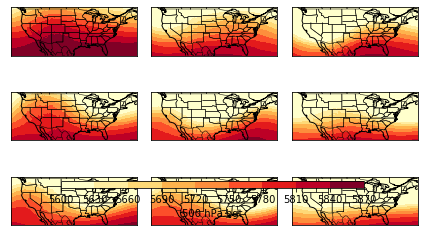

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(Nr, Nc, tight_layout = True, sharex=True,sharey = True)
#fig.subtitle('R occurrence',fontweight='bold')

#fig.subplots_adjust(bottom=0.55,left=0.1,hspace=None,wspace=0.2)

#gs = gridspec.GridSpec(Nr, Nc, hspace=None,wspace=None)#width_ratios=[1, 1, 1])
#gs1 = gridspec.GridSpec(2, 3)
#gs1.update(wspace=0.025, hspace=0.0)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons[lons>=-130.], lats[lats>=25.])

#np.squeeze(diurnallow[5,200,:,:])

images = []

vmin = np.nanmin(neurons)#min(image.get_array().min() for image in images)
vmax = np.nanmax(neurons)#max(image.get_array().max() for image in images)
if anom==1:
    clev = np.linspace(-200,200,11,endpoint=True)
    cmap = plt.get_cmap('PuOr_r')
else:
    clev = np.linspace(5600,5900,10,endpoint=False)
    cmap = plt.get_cmap('YlOrRd')
#clev = np.linspace(0,1e-4,10,endpoint=False)
#clev = np.linspace(0,15e-3,10,endpoint=False)
#clev = np.linspace(260,300,10,endpoint=False)
norm = BoundaryNorm(clev,ncolors=cmap.N,clip=True)


for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
#        images.append(axs[i ].imshow(data, cmap=cmap))
#        axs[i].label_outer()
        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=axs[i,j])
        xi, yi = m(lon, lat)

#        if i<(Nr-1):
#            m.drawparallels(np.arange(-80., 81., 15.), labels=[1,0,0,0], fontsize=5)
#            m.drawmeridians(np.arange(-180., 181., 30.), labels=[0,0,0,0], fontsize=5)
#        elif i==(Nr-1):
#            m.drawparallels(np.arange(-80., 81., 15.), labels=[1,0,0,0], fontsize=5)
#            m.drawmeridians(np.arange(-180., 181., 30.), labels=[0,0,0,1], fontsize=5)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        images = m.pcolormesh(xi,yi,neurons_matrix[i,j,:,:],cmap=cmap,ax=axs[i,j],norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf



#fig.subplots_adjust(right=0.7,hspace=0.4)
cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.025])       ###axes are rect['left','bottom','width','height']
cbar = fig.colorbar(images, cax=cbar_ax, orientation='horizontal')
#fig.tight_layout(pad=0)
#cbar = m.colorbar(fig, location='bottom', pad="10%")
cbar.set_label('500 hPa hgt')

# Add Title
#plt.title('Merged IR '+startdate+' '+enddate)
plt.show()

plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.savefig('dswe_python_som.pdf')
#axs[0].title.set_text('all')
#axs[1].title.set_text('L regime')
#axs[2].title.set_text('M regime')
#axs[3].title.set_text('H regime')
#plt.title('mean afternoon rain')

In [ ]:
#created .nc file with nodes

ncfile = nc.Dataset('dswe_neuron.nc','w',format='NETCDF4_CLASSIC')
data_out = np.empty([num,h500shape[1],h500shape[2]])

ncfile.createDimension('y',h500shape[1])
ncfile.createDimension('x',h500shape[2])
ncfile.createDimension('neu',num)

data= ncfile.createVariable('neuron',np.float32,('neu','y','x'))
latitudes= ncfile.createVariable('latitude',np.float32,('y'))
longitudes= ncfile.createVariable('longitude',np.float32,('x'))
latitudes.units = 'degrees_north'
longitudes.units = 'degrees_east'

latitudes[:] = lats[lats>=25.]
longitudes[:] = lons[lons>=-130.]
data[:] = neurons

ncfile.close()

In [ ]:
help(koh)

Help on module kohonen:

NAME
    kohonen

DESCRIPTION
    Python representation of an R package.
    description
    -----------
    
    
     \Sexpr[results=rd,stage=build]{tools:::Rd_package_description("#1")} kohonen Functions to train self-organising maps (SOMs). Also interrogation of the maps and prediction using trained maps are supported. The name of the package refers to Teuvo Kohonen, the inventor of the SOM.

DATA
    CreateStdDistancePointer = R object with classes: ('function',) mapped...
    CreateStdDistancePointers = R object with classes: ('function',) mappe...
    Hexagon = R object with classes: ('function',) mapped to:
    ObjectDistances = R object with classes: ('function',) mapped to:
    RcppBatchSupersom = R object with classes: ('function',) mapped to:
    RcppMap = R object with classes: ('function',) mapped to:
    RcppParallelBatchSupersom = R object with classes: ('function',) mappe...
    RcppSupersom = R object with classes: ('function',) mapped to:
   

In [ ]:
sumkoh = koh.summary_kohonen

In [ ]:
sumkoh(somq)

SOM of size 3x3 with a rectangular topology and a bubble neighbourhood function.
The number of data layers is 1.
Distance measure(s) used: sumofsquares.
Training data included: 1497 objects.
Mean distance to the closest unit in the map: 29748802.


<rpy2.rinterface.NULLType object at 0x7f5b0889fd20> [RTYPES.NILSXP]

In [ ]:
#predict BMU utilizing euclidean distance

help(koh.som)
if anom==1:
    pred = koh.map_kohonen(somq,h500anomreshape)
    pred_nw = koh.map_kohonen(somq,h500anom_nw_reshape)
    pred_sierra = koh.map_kohonen(somq,h500anom_sierra_reshape)
    pred_rockies = koh.map_kohonen(somq,h500anom_rockies_reshape)
    pred_gl = koh.map_kohonen(somq,h500anom_gl_reshape)
    pred_ne = koh.map_kohonen(somq,h500anom_ne_reshape)
#    pred = koh.predict_kohonen(somq,h500anomreshape)
#    pred_nw = koh.predict_kohonen(somq,h500anom_nw_reshape)
#    pred_sierra = koh.predict_kohonen(somq,h500anom_sierra_reshape)
#    pred_rockies = koh.predict_kohonen(somq,h500anom_rockies_reshape)
#    pred_gl = koh.predict_kohonen(somq,h500anom_gl_reshape)
#    pred_ne = koh.predict_kohonen(somq,h500anom_ne_reshape)
else:
    pred = koh.map_kohonen(somq,h500reshape)
    pred_nw = koh.map_kohonen(somq,h500_nw_reshape)
    pred_sierra = koh.map_kohonen(somq,h500_sierra_reshape)
    pred_rockies = koh.map_kohonen(somq,h500_rockies_reshape)
    pred_gl = koh.map_kohonen(somq,h500_gl_reshape)
    pred_ne = koh.map_kohonen(somq,h500_ne_reshape)
    pred_ros = koh.map_kohonen(somq,h500reshape_ros)
    pred_nw_ros = koh.map_kohonen(somq,h500_nw_ros_reshape)
    pred_sierra_ros = koh.map_kohonen(somq,h500_sierra_ros_reshape)
    pred_rockies_ros = koh.map_kohonen(somq,h500_rockies_ros_reshape)
    pred_gl_ros = koh.map_kohonen(somq,h500_gl_ros_reshape)
    pred_ne_ros = koh.map_kohonen(somq,h500_ne_ros_reshape)
    pred_nor = koh.map_kohonen(somq,h500reshape_nor)
    pred_nw_nor = koh.map_kohonen(somq,h500_nw_nor_reshape)
    pred_sierra_nor = koh.map_kohonen(somq,h500_sierra_nor_reshape)
    pred_rockies_nor = koh.map_kohonen(somq,h500_rockies_nor_reshape)
    pred_gl_nor = koh.map_kohonen(somq,h500_gl_nor_reshape)
    pred_ne_nor = koh.map_kohonen(somq,h500_ne_nor_reshape)
#    pred = koh.predict_kohonen(somq,h500reshape)
#    pred_nw = koh.predict_kohonen(somq,h500_nw_reshape)
#    pred_sierra = koh.predict_kohonen(somq,h500_sierra_reshape)
#    pred_rockies = koh.predict_kohonen(somq,h500_rockies_reshape)
#    pred_gl = koh.predict_kohonen(somq,h500_gl_reshape)
#    pred_ne = koh.predict_kohonen(somq,h500_ne_reshape)

Help on DocumentedSTFunction in module rpy2.robjects.functions object:

class DocumentedSTFunction(SignatureTranslatedFunction)
 |  DocumentedSTFunction(sexp, init_prm_translate=None, packagename=None)
 |  
 |  Python representation of an R function, where
 |  the names in named argument are translated to valid
 |  argument names in Python.
 |  
 |  Method resolution order:
 |      DocumentedSTFunction
 |      SignatureTranslatedFunction
 |      Function
 |      rpy2.robjects.robject.RObjectMixin
 |      rpy2.rinterface.SexpClosure
 |      rpy2.rinterface_lib.sexp.Sexp
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sexp, init_prm_translate=None, packagename=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from SignatureTranslatedFunction:
 |  
 |  __call__(self, *args, **kwargs)
 |      Call self as a function.
 |  
 |  ------

In [ ]:
#comparing koh.map_kohonen and koh.predict_kohonen

pred2 = koh.predict_kohonen(somq,newdata=h500_nw_reshape,trainingdata=h500reshape)

In [ ]:
print(koh.predict_kohonen)

function (object, newdata = NULL, unit.predictions = NULL, trainingdata = NULL, 
    whatmap = NULL, threshold = 0, maxNA.fraction = object$maxNA.fraction, 
    ...) 
{
    codeNcols <- sapply(object$codes, ncol)
    ncodes <- nrow(object$codes[[object$whatmap[1]]])
    if (is.null(whatmap)) {
        whatmap <- object$whatmap
    }
    else {
        whatmap <- check.whatmap(object, whatmap)
    }
    if (!is.null(unit.predictions)) {
        if (!is.list(unit.predictions)) 
            unit.predictions <- list(unit.predictions)
        if (any(isFactorUnPred <- sapply(unit.predictions, is.factor))) 
            unit.predictions[isFactorUnPred] <- lapply(unit.predictions[isFactorPred], 
                classvec2classmat)
    }
    else {
        if (is.null(trainingdata)) {
            trainingdata <- object$data
        }
        else {
            if (is.null(trainingdata)) 
                stop("Missing trainingdata argument, no data available in kohonen object either")
           

In [ ]:
pred_nw[0]

4.000000,6.000000,6.000000,...,4.000000,1.000000,1.000000


In [ ]:
pred2[1]

4.000000,6.000000,6.000000,...,4.000000,1.000000,1.000000


In [ ]:
np.ravel(pred_nw[0])

array([4., 6., 6., 6., 1., 1., 1., 3., 3., 9., 8., 9., 5., 5., 7., 7., 7.,
       8., 8., 8., 7., 7., 7., 7., 7., 4., 4., 4., 9., 5., 5., 6., 4., 7.,
       3., 5., 5., 3., 4., 4., 9., 7., 6., 6., 5., 9., 9., 9., 9., 6., 6.,
       6., 7., 7., 7., 1., 1., 4., 4., 9., 9., 8., 9., 9., 6., 6., 7., 2.,
       2., 8., 8., 7., 7., 1., 6., 5., 9., 6., 5., 8., 7., 5., 8., 6., 6.,
       9., 6., 4., 5., 7., 6., 6., 3., 5., 5., 4., 4., 7., 7., 7., 2., 1.,
       9., 4., 2., 4., 4., 3., 3., 6., 6., 7., 9., 9., 6., 6., 6., 3., 3.,
       3., 3., 3., 6., 6., 7., 7., 7., 7., 4., 6., 2., 1., 4., 1., 1., 5.,
       5., 2., 3., 3., 6., 9., 7., 7., 8., 8., 9., 5., 7., 6., 2., 4., 1.,
       9., 8., 7., 8., 9., 9., 3., 4., 2., 4., 4., 4., 4., 1., 1., 1., 5.,
       8., 8., 7., 9., 9., 7., 9., 9., 9., 3., 3., 6., 7., 7., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 2., 1., 1., 1., 1., 7., 7., 8., 8., 7.,
       8., 8., 9., 3., 4., 4., 1., 1., 4., 6., 1., 9., 6., 7., 7., 8., 6.,
       5., 2., 2., 2., 2.

In [ ]:
np.ravel(pred2[1])

array([4., 6., 6., 6., 1., 1., 1., 3., 3., 9., 8., 9., 5., 5., 7., 7., 7.,
       8., 8., 8., 7., 7., 7., 7., 7., 4., 4., 4., 9., 5., 5., 6., 4., 7.,
       3., 5., 5., 3., 4., 4., 9., 7., 6., 6., 5., 9., 9., 9., 9., 6., 6.,
       6., 7., 7., 7., 1., 1., 4., 4., 9., 9., 8., 9., 9., 6., 6., 7., 2.,
       2., 8., 8., 7., 7., 1., 6., 5., 9., 6., 5., 8., 7., 5., 8., 6., 6.,
       9., 6., 4., 5., 7., 6., 6., 3., 5., 5., 4., 4., 7., 7., 7., 2., 1.,
       9., 4., 2., 4., 4., 3., 3., 6., 6., 7., 9., 9., 6., 6., 6., 3., 3.,
       3., 3., 3., 6., 6., 7., 7., 7., 7., 4., 6., 2., 1., 4., 1., 1., 5.,
       5., 2., 3., 3., 6., 9., 7., 7., 8., 8., 9., 5., 7., 6., 2., 4., 1.,
       9., 8., 7., 8., 9., 9., 3., 4., 2., 4., 4., 4., 4., 1., 1., 1., 5.,
       8., 8., 7., 9., 9., 7., 9., 9., 9., 3., 3., 6., 7., 7., 4., 4., 5.,
       4., 4., 4., 4., 4., 4., 4., 2., 1., 1., 1., 1., 7., 7., 8., 8., 7.,
       8., 8., 9., 3., 4., 4., 1., 1., 4., 6., 1., 9., 6., 7., 7., 8., 6.,
       5., 2., 2., 2., 2.

In [ ]:
(np.ravel(pred_nw[0]) - np.ravel(pred2[1]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
np.shape(h500[:,lats>=25.,:][:,:,lons>=-130.])
#h500shape[1]

(1497, 51, 105)

(array([  19,   20,   21,   22,   78,  113,  114,  145,  146,  147,  148,
        149,  170,  240,  241,  337,  338,  339,  340,  341,  343,  344,
        345,  346,  347,  348,  349,  350,  351,  352,  353,  354,  422,
        423,  424,  425,  426,  427,  518,  519,  565,  566,  627,  631,
        632,  633,  634,  635,  636,  693,  698,  699,  701,  723,  733,
        734,  735,  736,  737,  738,  775,  776,  777,  778,  779,  780,
        805,  834,  835,  839,  840,  841,  842,  882,  888,  889,  890,
        908,  909,  910,  911,  912,  913,  914,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1055, 1056, 1057, 1058, 1113, 1114,
       1118, 1119, 1120, 1121, 1122, 1205, 1206, 1209, 1210, 1211, 1212,
       1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223,
       1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1257, 1258,
       1259, 1279, 1284, 1288, 1335, 1336, 1337, 1341, 1342, 1343, 1344,
       1345, 1346, 1347, 1348, 1349, 1350, 1400, 1

(1, 51, 105)
(array([   2,    9,   25,   26,   27,   29,   45,   46,   47,   48,   92,
         93,   94,  118,  119,  120,  136,  139,  153,  155,  172,  175,
        220,  249,  250,  251,  252,  267,  268,  295,  299,  316,  317,
        323,  327,  357,  368,  369,  371,  380,  388,  399,  404,  405,
        445,  452,  483,  484,  521,  537,  538,  539,  540,  541,  542,
        543,  544,  546,  548,  549,  568,  569,  590,  591,  594,  595,
        596,  597,  598,  599,  600,  601,  602,  603,  618,  619,  637,
        638,  639,  640,  674,  675,  676,  677,  678,  679,  680,  702,
        704,  705,  706,  712,  713,  755,  756,  757,  758,  765,  771,
        772,  784,  785,  786,  787,  806,  816,  817,  826,  827,  857,
        858,  863,  864,  868,  917,  919,  954,  955,  960,  961,  962,
        973,  974, 1014, 1023, 1024, 1037, 1038, 1092, 1093, 1094, 1095,
       1096, 1109, 1128, 1129, 1146, 1147, 1148, 1149, 1150, 1151, 1152,
       1165, 1166, 1167, 1175, 1177, 

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behav

0
0
a)
0
1
b)
0
2
c)
1
0
d)
1
1
e)
1
2
f)
2
0
g)
2
1
h)
2
2
i)


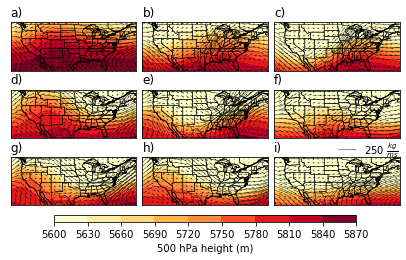

ivt = [[ 80.27526739  78.82987717  77.0370627  ... 103.98101637 100.21281971
   94.64248822]
 [ 79.23211345  77.9482335   76.31838894 ...  95.75146969  91.07885729
   84.12980407]
 [ 78.60725035  77.3264048   75.90260169 ...  88.98712425  84.11900185
   77.31961836]
 ...
 [ 89.69616506  83.85294693  77.76804209 ...  77.3161664   75.90100067
   74.18269172]
 [ 89.61854861  81.69840433  75.37433737 ...  69.68824979  69.58192313
   68.2550692 ]
 [ 89.01354808  82.48444713  76.62067868 ...  62.06562512  60.43961475
   59.0715397 ]]
ivt = [[105.3709259  103.34456635 101.47858429 ... 195.33148193 190.84594727
  185.15071106]
 [105.77957916 103.40307617 101.27857208 ... 195.4520874  189.8215332
  183.67402649]
 [107.29042816 104.47983551 101.70484161 ... 196.24789429 189.71647644
  184.46456909]
 ...
 [160.43380737 154.13626099 147.53396606 ... 156.29071045 154.66677856
  159.08998108]
 [158.94450378 151.20872498 145.8800354  ... 159.52934265 163.28729248
  167.20698547]
 [156.94897461 150.07

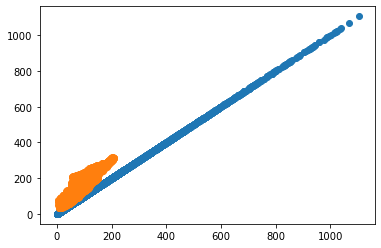

In [ ]:
#500 heights corresponding to map predictions
##this is actually the primary file to use in the manuscript, including both heights and IVT corresponding to heights
hgt_correspond = np.empty((Nr,Nc,h500shape[1],h500shape[2]))
print(np.where(np.ravel(pred[0])==1))
ivt_correspond = np.empty((Nr,Nc,h500shape[1],h500shape[2]))
ivtu_correspond = np.empty((Nr,Nc,h500shape[1],h500shape[2]))
ivtv_correspond = np.empty((Nr,Nc,h500shape[1],h500shape[2]))

h500cut = h500[:,lats>=25.,:][:,:,lons>=-130.]
ivtcut = ivt[:,lats>=25.,:][:,:,lons>=-130.]
ivtucut = ivtu[:,lats>=25.,:][:,:,lons>=-130.]
ivtvcut = ivtv[:,lats>=25.,:][:,:,lons>=-130.]

pred[0]
for i in range(Nr):
    for j in range(Nc):
        print(np.where(np.ravel(pred[0])==(i+1)))
        k = i * Nc + j
        print(i)
        print(j)
        print(k+1)
        print(np.shape(np.mean(h500cut[np.where(np.ravel(pred[0])==(k+1)),:,:],axis=1)))
        hgt_correspond[i,j,:,:] = np.mean(h500cut[np.where(np.ravel(pred[0])==(k+1)),:,:],axis=1)
        ivt_correspond[i,j,:,:] = np.mean(ivtcut[np.where(np.ravel(pred[0])==(k+1)),:,:],axis=1)
        ivtu_correspond[i,j,:,:] = np.mean(ivtucut[np.where(np.ravel(pred[0])==(k+1)),:,:],axis=1)
        ivtv_correspond[i,j,:,:] = np.mean(ivtvcut[np.where(np.ravel(pred[0])==(k+1)),:,:],axis=1)


fig, axs = plt.subplots(Nr, Nc)#, tight_layout = True, sharex=True,sharey = True)
#fig.subtitle('R occurrence',fontweight='bold')
#fig.subplots_adjust(bottom=0.55,left=0.1,hspace=None,wspace=0.2)

#gs = gridspec.GridSpec(Nr, Nc, hspace=None,wspace=None)#width_ratios=[1, 1, 1])
#gs1 = gridspec.GridSpec(2, 3)
#gs1.update(wspace=0.025, hspace=0.0)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons[lons>=-130.], lats[lats>=25.])

#np.squeeze(diurnallow[5,200,:,:])

images = []

vmin = np.nanmin(neurons)#min(image.get_array().min() for image in images)
vmax = np.nanmax(neurons)#max(image.get_array().max() for image in images)
if anom==1:
    clev = np.linspace(-200,200,11,endpoint=True)
    cmap = plt.get_cmap('PuOr_r')
else:
    clev = np.linspace(5600,5900,10,endpoint=False)#(5600,5900,10,endpoint=False)
    cmap = plt.get_cmap('YlOrRd')


#clev = np.linspace(0,250,11,endpoint=True)
#clev = np.linspace(0,1e-4,10,endpoint=False)
#clev = np.linspace(0,15e-3,10,endpoint=False)
#clev = np.linspace(260,300,10,endpoint=False)
norm = BoundaryNorm(clev,ncolors=cmap.N,clip=True)
labelindex = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)','k)','l)','m)','n)']

#gs = gridspec.GridSpec(Nr, Nc,
#         wspace=0.05, hspace=0.0, top=0.7, bottom=0.2, left=0.05, right=0.95)

gs = gridspec.GridSpec(Nr, Nc,
         wspace=0.05, hspace=0.0, top=0.925, bottom=0.225, left=0.05, right=0.95)

clevivt = np.linspace(0,250,11,endpoint=True)
normivt = BoundaryNorm(clevivt,ncolors=cmap.N,clip=True)

##ax=axs[i,j] or ax=plt.subplot[i,j]?????

for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
#        images.append(axs[i ].imshow(data, cmap=cmap))
#        axs[i].label_outer()
        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[i,j]))
        xi, yi = m(lon, lat)

#        if i<(Nr-1):
#            m.drawparallels(np.arange(-80., 81., 15.), labels=[1,0,0,0], fontsize=5)
#            m.drawmeridians(np.arange(-180., 181., 30.), labels=[0,0,0,0], fontsize=5)
#        elif i==(Nr-1):
#            m.drawparallels(np.arange(-80., 81., 15.), labels=[1,0,0,0], fontsize=5)
#            m.drawmeridians(np.arange(-180., 181., 30.), labels=[0,0,0,1], fontsize=5)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        ax = plt.subplot(gs[i,j])#axs[i,j]
        ax.set_title(labelindex[i*Nc + j],loc='left')
        images = m.pcolormesh(xi,yi,neurons_matrix[i,j,:,:],cmap=cmap,ax=plt.subplot(gs[i,j]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf
#        images = m.pcolormesh(xi,yi,ivt_correspond[i,j,:,:],cmap=cmap,ax=axs[i,j],norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf
#        M = np.hypot(ivtu_correspond[i,j,::4,::4],ivtv_correspond[i,j,::4,::4])
#        images = m.quiver(xi[::4,::4],yi[::4,::4],ivtu_correspond[i,j,::4,::4],ivtv_correspond[i,j,::4,::4],M,cmap='BuPu',ax=axs[i,j],scale=1000,scale_units='inches',norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf
        images = m.quiver(xi[::4,::4],yi[::4,::4],ivtu_correspond[i,j,::4,::4],ivtv_correspond[i,j,::4,::4],cmap=cmap,ax=plt.subplot(gs[i,j]),scale=1000,scale_units='inches',norm=norm)#,clim=(0,500))#norm=normivt) #clev is 4th argument #norm is 5th #pcolormesh or contourf
    ### for whatever reason, norm=norm needs to be in quiver to be able to accurately convey colorbar
#        ax.imshow(images)
        print(i)
        print(j)
        print(labelindex[i*Nc + j])
#        plt.show()

#plt.quiverkey(images, 0.85, 0.45, 250, r'250 $\frac{kg}{m s}$', labelpos='E',coordinates='figure')
plt.quiverkey(images, 0.85, 0.45, 250, r'250 $\frac{kg}{m s}$', labelpos='E',coordinates='figure')
#fig.subplots_adjust(right=0.7,hspace=0.4)
cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.025])       ###axes are rect['left','bottom','width','height']
cbar = fig.colorbar(images, cax=cbar_ax, orientation='horizontal')
#fig.tight_layout(pad=0)
#cbar = m.colorbar(fig, location='bottom', pad="10%")
if anom==1:
    cbar.set_label('500 hPa hgt anomaly (m)')
else:
    cbar.set_label('500 hPa height (m)')

# Add Title
#plt.title('Merged IR '+startdate+' '+enddate)
plt.show()
#fig.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.savefig('dswe_hgt_correspond.pdf')


print('ivt = ' + str(np.sqrt((ivtu_correspond[0,0,:,:])**2 + (ivtv_correspond[0,0,:,:])**2)))
print('ivt = ' + str(ivt_correspond[0,0,:,:]))


plt.scatter(np.sqrt((ivtu[0,:,:])**2 + (ivtv[0,:,:])**2),ivt[0,:,:])
plt.scatter(np.sqrt((ivtu_correspond[0,0,:,:])**2 + (ivtv_correspond[0,0,:,:])**2),ivt_correspond[0,0,:,:])

urand = np.empty((100))
vrand = np.empty((100))
sqrand = np.empty((100))
for i in range(100):
    urand[i] = np.random.rand()
    vrand[i] = np.random.randn()
    sqrand[i] = np.sqrt(urand[i]**2 + vrand[i]**2)

print((np.sqrt(np.mean(urand)**2+np.mean(vrand)**2)))
print(np.mean(sqrand))




In [ ]:
#create .nc files with som predictions

ncfile3 = nc.Dataset('pred_dswe.nc','w',format='NETCDF4_CLASSIC')
ncfile3.createDimension('time',h500shape[0])
ncfile3.createDimension('time_nw',h500_nw_shape[0])
ncfile3.createDimension('time_sierra',h500_sierra_shape[0])
ncfile3.createDimension('time_gl',h500_gl_shape[0])
ncfile3.createDimension('time_ne',h500_ne_shape[0])

#data= ncfile3.createVariable('pred_supersom',np.float32,('time'))
data1= ncfile3.createVariable('pred_som',np.float32,('time'))
data2= ncfile3.createVariable('pred_som_nw',np.float32,('time_nw'))
data3= ncfile3.createVariable('pred_som_sierra',np.float32,('time_sierra'))
data4= ncfile3.createVariable('pred_som_gl',np.float32,('time_gl'))
data5= ncfile3.createVariable('pred_som_ne',np.float32,('time_ne'))

#data[:] = predsuper[0]
data1[:] = pred[0]
data2[:] = pred_nw[0]
data3[:] = pred_sierra[0]
data4[:] = pred_gl[0]
data5[:] = pred_ne[0]


ncfile3.close()

In [ ]:
#count number of maps for each regional snowmelt event corresponding to each som node
##dimensions for count_pred => (regions x map number)
count_pred = np.empty(([6,num]),float)
count_pred_ros_nor = np.empty(([12,num]),float)

print(np.shape(count_pred))

for i in range(num):
    print(i)
    count_pred[0,i] = count(pred[0],i+1)
    count_pred[1,i] = count(pred_nw[0],i+1)
    count_pred[2,i] = count(pred_sierra[0],i+1)
    count_pred[3,i] = count(pred_rockies[0],i+1)
    count_pred[4,i] = count(pred_gl[0],i+1)
    count_pred[5,i] = count(pred_ne[0],i+1)

for i in range(num):
    print(i)
    count_pred_ros_nor[0,i] = count(pred_ros[0],i+1)
    count_pred_ros_nor[1,i] = count(pred_nw_ros[0],i+1)
    count_pred_ros_nor[2,i] = count(pred_sierra_ros[0],i+1)
    count_pred_ros_nor[3,i] = count(pred_rockies_ros[0],i+1)
    count_pred_ros_nor[4,i] = count(pred_gl_ros[0],i+1)
    count_pred_ros_nor[5,i] = count(pred_ne_ros[0],i+1)
    count_pred_ros_nor[6,i] = count(pred_nor[0],i+1)
    count_pred_ros_nor[7,i] = count(pred_nw_nor[0],i+1)
    count_pred_ros_nor[8,i] = count(pred_sierra_nor[0],i+1)
    count_pred_ros_nor[9,i] = count(pred_rockies_nor[0],i+1)
    count_pred_ros_nor[10,i] = count(pred_gl_nor[0],i+1)
    count_pred_ros_nor[11,i] = count(pred_ne_nor[0],i+1)

(6, 9)
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


[173. 213. 172. 176. 178. 197. 147. 110. 131.]
[27. 15. 22. 42. 22. 38. 46. 29. 31.]
[24. 23. 13. 38. 13. 22. 31. 29. 21.]
[95. 66. 30. 88. 52. 71. 41. 26. 23.]
[ 4. 37. 50. 12. 24. 27. 11.  7.  9.]
[ 3. 48. 56. 11. 61. 24. 22. 17. 20.]


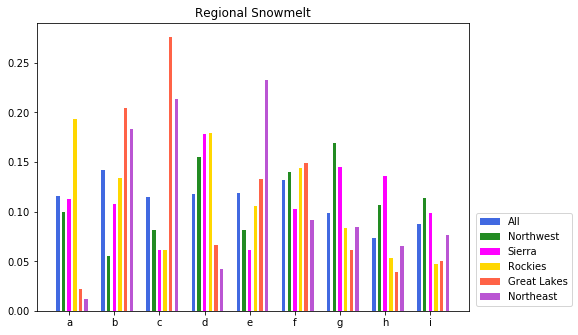

In [ ]:
for i in range(6):
    print(count_pred[i,:])
    count_pred[i,:] = count_pred[i,:] / np.sum(count_pred[i,:])

X = np.arange(1,num+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barwidth = 0.075
ax.bar(X - 0.25, count_pred[0,:], color = 'royalblue', width = barwidth)
ax.bar(X - 0.125, count_pred[1,:], color = 'forestgreen', width = barwidth)
ax.bar(X + 0.0, count_pred[2,:], color = 'fuchsia', width = barwidth)
ax.bar(X + 0.125, count_pred[3,:], color = 'gold', width = barwidth)
ax.bar(X + 0.25, count_pred[4,:], color = 'tomato', width = barwidth)
ax.bar(X + 0.375, count_pred[5,:], color = 'mediumorchid', width = barwidth)
plt.legend(('All','Northwest','Sierra','Rockies','Great Lakes','Northeast'),bbox_to_anchor=(0.25, 0., 1., .102),loc='lower right')
plt.title('Regional Snowmelt')
#plt.xticks([1,2,3,4,5,6],['a','b','c','d','e','f'])
plt.xticks([1,2,3,4,5,6,7,8,9],['a','b','c','d','e','f','g','h','i'])
plt.show()

fig.savefig('dswe_bar_som.pdf',bbox_inches='tight')   ##bbox_inches keeps pdf from cutting off


[19. 56. 69. 16. 87. 52. 25. 22. 61.]
[ 4.  8.  9.  5.  9. 18. 11. 11. 19.]
[ 0.  3.  8.  1.  3.  6.  1.  5. 12.]
[11. 19. 16.  3. 20. 12.  5.  3.  5.]
[ 0.  7. 19.  1. 13.  1.  1.  0.  2.]
[ 0.  9. 13.  3. 31.  3.  5.  1.  9.]
[154. 157. 103. 160.  91. 145. 122.  88.  70.]
[23.  7. 13. 37. 13. 20. 35. 18. 12.]
[24. 20.  5. 37. 10. 16. 30. 24.  9.]
[84. 47. 14. 85. 32. 59. 36. 23. 18.]
[ 4. 30. 31. 11. 11. 26. 10.  7.  7.]
[ 3. 39. 43.  8. 30. 21. 17. 16. 11.]


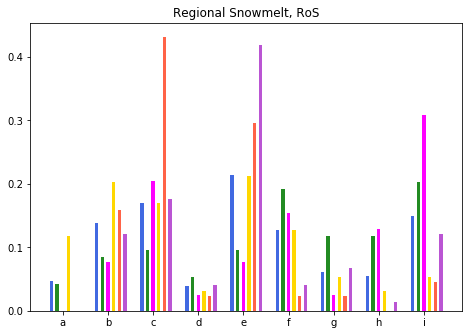

In [ ]:
##FOR ROS MAPS
for i in range(12):
    print(count_pred_ros_nor[i,:])
    count_pred_ros_nor[i,:] = count_pred_ros_nor[i,:] / np.sum(count_pred_ros_nor[i,:])

X = np.arange(1,num+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barwidth = 0.075
ax.bar(X - 0.25, count_pred_ros_nor[0,:], color = 'royalblue', width = barwidth)
ax.bar(X - 0.125, count_pred_ros_nor[1,:], color = 'forestgreen', width = barwidth)
ax.bar(X + 0.0, count_pred_ros_nor[2,:], color = 'fuchsia', width = barwidth)
ax.bar(X + 0.125, count_pred_ros_nor[3,:], color = 'gold', width = barwidth)
ax.bar(X + 0.25, count_pred_ros_nor[4,:], color = 'tomato', width = barwidth)
ax.bar(X + 0.375, count_pred_ros_nor[5,:], color = 'mediumorchid', width = barwidth)
plt.title('Regional Snowmelt, RoS')
#plt.xticks([1,2,3,4,5,6],['a','b','c','d','e','f'])
plt.xticks([1,2,3,4,5,6,7,8,9],['a','b','c','d','e','f','g','h','i'])
plt.show()

fig.savefig('dswe_bar_som_ros.pdf',bbox_inches='tight')   ##bbox_inches keeps pdf from cutting off


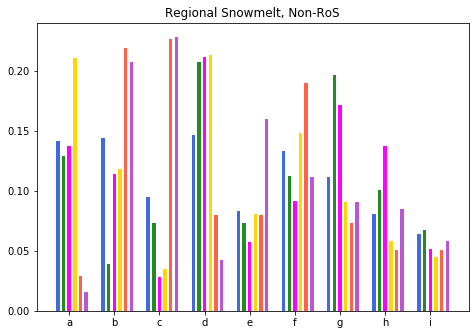

In [ ]:
##FOR NOR MAPS

X = np.arange(1,num+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barwidth = 0.075
ax.bar(X - 0.25, count_pred_ros_nor[6,:], color = 'royalblue', width = barwidth)
ax.bar(X - 0.125, count_pred_ros_nor[7,:], color = 'forestgreen', width = barwidth)
ax.bar(X + 0.0, count_pred_ros_nor[8,:], color = 'fuchsia', width = barwidth)
ax.bar(X + 0.125, count_pred_ros_nor[9,:], color = 'gold', width = barwidth)
ax.bar(X + 0.25, count_pred_ros_nor[10,:], color = 'tomato', width = barwidth)
ax.bar(X + 0.375, count_pred_ros_nor[11,:], color = 'mediumorchid', width = barwidth)
plt.title('Regional Snowmelt, Non-RoS')
#plt.xticks([1,2,3,4,5,6],['a','b','c','d','e','f'])
plt.xticks([1,2,3,4,5,6,7,8,9],['a','b','c','d','e','f','g','h','i'])
plt.show()

fig.savefig('dswe_bar_som_nor.pdf',bbox_inches='tight')   ##bbox_inches keeps pdf from cutting off


In [ ]:
np.sum(count_pred,axis=1)

array([1., 1., 1., 1., 1., 1.])

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behav

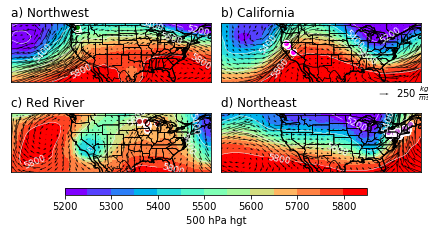

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 432x288 with 0 Axes>

In [ ]:
##case study plots

g = nc.Dataset('/home/weltyj/Desktop/som_test/dswetimeyyyymmdd.nc','r')
dsweyyyymmdd = g.variables["dswetime"][:]
dswelats = g.variables["lat"][:]
dswelons = g.variables["lon"][:]
dswelon, dswelat = np.meshgrid(dswelons[:], dswelats[:])

fig, axs = plt.subplots(2, 2,tight_layout = True, sharex=True,sharey = True)
#fig.subtitle('R occurrence',fontweight='bold')

#fig.subplots_adjust(bottom=0.55,left=0.1,hspace=None,wspace=0.2)

#gs = gridspec.GridSpec(Nr, Nc, hspace=None,wspace=None)#width_ratios=[1, 1, 1])
#gs1 = gridspec.GridSpec(2, 3)
#gs1.update(wspace=0.025, hspace=0.0)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons[:], lats[:])

#np.squeeze(diurnallow[5,200,:,:])

images = []

vmin = np.nanmin(neurons)#min(image.get_array().min() for image in images)
vmax = np.nanmax(neurons)#max(image.get_array().max() for image in images)
if anom==1:
    clev = np.linspace(-200,200,11,endpoint=True)
    cmap = plt.get_cmap('PuOr_r')
else:
    clev = np.linspace(5200,5900,14,endpoint=False)
    cmap = plt.get_cmap('rainbow')
#clev = np.linspace(0,1e-4,10,endpoint=False)
#clev = np.linspace(0,15e-3,10,endpoint=False)
#clev = np.linspace(260,300,10,endpoint=False)
norm = BoundaryNorm(clev,ncolors=cmap.N,clip=True)

clevivt = np.linspace(0,250,11,endpoint=True)
normivt = BoundaryNorm(clevivt,ncolors=cmap.N,clip=True)

timevec = [[19961231,20170210],[19970403,19960120]]
colmat = [['green','magenta'],['firebrick','mediumorchid']]
latmin = [[42,32],[40,40]]
latmax = [[52,42],[50,50]]
lonmin = [[-125,-125],[-100,-80]]
lonmax = [[-118,-118],[-85,-65]]
labelindex = [['a) Northwest','b) California'],['c) Red River','d) Northeast']]
gs = gridspec.GridSpec(2, 2,
         wspace=0.05, hspace=0.0, top=0.85, bottom=0.225, left=0.025, right=0.975)


for i in range(2):
    for j in range(2):

        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-150,urcrnrlon=-65,resolution='c',ax=axs[i,j])
        xi, yi = m(lon, lat)

        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        images = m.pcolormesh(xi,yi,h500[time==timevec[i][j],:,:][0],cmap=cmap,ax=plt.subplot(gs[i,j]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf
        plt.subplot(gs[i,j]).set_title(labelindex[i][j],loc='left')

cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.025])       ###axes are rect['left','bottom','width','height']
cbar = fig.colorbar(images, cax=cbar_ax, orientation='horizontal')
#fig.tight_layout(pad=0)
#cbar = m.colorbar(fig, location='bottom', pad="10%")
cbar.set_label('500 hPa hgt')

for i in range(2):
    for j in range(2):

        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-150,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[i,j]))
        xi, yi = m(lon, lat)

        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        images = m.contour(xi,yi,h500[time==timevec[i][j],:,:][0],[5200,5400,5600,5800],ax=plt.subplot(gs[i,j]),colors='ghostwhite',linewidths=0.5) #clev is 4th argument #norm is 5th #pcolormesh or contourf
        plt.subplot(gs[i,j]).clabel(images,inline=True, fontsize=9,fmt='%1.0f' )

for i in range(2):
    for j in range(2):

        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-150,urcrnrlon=-65,resolution='c',ax=axs[i,j])
        xi, yi = m(lon, lat)

        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        images = m.quiver(xi[::4,::4],yi[::4,::4],ivtu[time==timevec[i][j],::4,::4][0],ivtv[time==timevec[i][j],::4,::4][0],ax=plt.subplot(gs[i,j]),scale=2000,scale_units='inches')#clim=(0,10))#norm=normivt) #clev is 4th argument #norm is 5th #pcolormesh or contourf

plt.quiverkey(images, 0.9, 0.55, 250, r'250 $\frac{kg}{m s}$', labelpos='E',coordinates='figure')

for i in range(2):
    for j in range(2):
        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-150,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[i,j]))
        xi, yi = m(dswelon[(dsweyyyymmdd==timevec[i][j])&(dswelon>=lonmin[i][j])&(dswelon<=lonmax[i][j])&(dswelat>=latmin[i][j])&(dswelat<=latmax[i][j])],dswelat[(dsweyyyymmdd==timevec[i][j])&(dswelon>=lonmin[i][j])&(dswelon<=lonmax[i][j])&(dswelat>=latmin[i][j])&(dswelat<=latmax[i][j])])
        np.shape(xi)
        np.shape(yi)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        images = m.scatter(xi,yi,marker="o",color=colmat[i][j],linewidths=1,edgecolors='w')


#fig.subplots_adjust(right=0.7,hspace=0.4)


# Add Title
#plt.title('Merged IR '+startdate+' '+enddate)
plt.show()

plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.savefig('dswe_case_studies.pdf')
#axs[0].title.set_text('all')
#axs[1].title.set_text('L regime')
#axs[2].title.set_text('M regime')
#axs[3].title.set_text('H regime')
#plt.title('mean afternoon rain')

In [ ]:
np.shape(yi)

(694,)

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. U

/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:92: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 

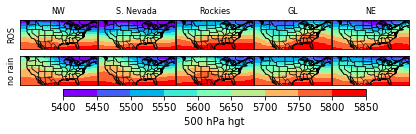

In [ ]:
##composite maps for RoS, no rain

h500_ros_reg = np.mean(h500_nw_ros,axis=0)
h500_nor_reg = np.mean(h500_nw_nor,axis=0)
images = []

clev = np.linspace(5400,5900,10,endpoint=False)
cmap = plt.get_cmap('rainbow')
norm = BoundaryNorm(clev,ncolors=cmap.N,clip=True)



fig, axs = plt.subplots(2, 5)
gs = gridspec.GridSpec(2, 5,
         wspace=0.02, hspace=0.0, top=0.6, bottom=0.35, left=0.05, right=0.95)

plt.subplot(gs[0,0]).set_title('NW',fontsize=8)
plt.subplot(gs[0,0]).set_ylabel('ROS',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[0,0]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_ros_reg,cmap=cmap,ax=plt.subplot(gs[0,0]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf

plt.subplot(gs[1,0]).set_ylabel('no rain',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[1,0]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_nor_reg,cmap=cmap,ax=plt.subplot(gs[1,0]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf



h500_ros_reg = np.mean(h500_sierra_ros,axis=0)
h500_nor_reg = np.mean(h500_sierra_nor,axis=0)

plt.subplot(gs[0,1]).set_title('S. Nevada',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[0,1]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_ros_reg,cmap=cmap,ax=plt.subplot(gs[0,1]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf

m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[1,1]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_nor_reg,cmap=cmap,ax=plt.subplot(gs[1,1]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf



h500_ros_reg = np.mean(h500_rockies_ros,axis=0)
h500_nor_reg = np.mean(h500_rockies_nor,axis=0)

plt.subplot(gs[0,2]).set_title('Rockies',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[0,2]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_ros_reg,cmap=cmap,ax=plt.subplot(gs[0,2]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf

m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[1,2]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_nor_reg,cmap=cmap,ax=plt.subplot(gs[1,2]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf



h500_ros_reg = np.mean(h500_gl_ros,axis=0)
h500_nor_reg = np.mean(h500_gl_nor,axis=0)

plt.subplot(gs[0,3]).set_title('GL',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[0,3]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_ros_reg,cmap=cmap,ax=plt.subplot(gs[0,3]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf

m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[1,3]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_nor_reg,cmap=cmap,ax=plt.subplot(gs[1,3]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf




h500_ros_reg = np.mean(h500_ne_ros,axis=0)
h500_nor_reg = np.mean(h500_ne_nor,axis=0)

plt.subplot(gs[0,4]).set_title('NE',fontsize=8)
m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[0,4]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_ros_reg,cmap=cmap,ax=plt.subplot(gs[0,4]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf

m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
    llcrnrlon=-130,urcrnrlon=-65,resolution='c',ax=plt.subplot(gs[1,4]))
xi, yi = m(lon, lat)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
images = m.pcolormesh(xi,yi,h500_nor_reg,cmap=cmap,ax=plt.subplot(gs[1,4]),norm=norm) #clev is 4th argument #norm is 5th #pcolormesh or contourf
cbar_ax = fig.add_axes([0.15, 0.325, 0.7, 0.025])       ###axes are rect['left','bottom','width','height']
cbar = fig.colorbar(images, cax=cbar_ax, orientation='horizontal')
cbar.set_label('500 hPa hgt')

plt.show()
fig.savefig('dswe_ros_composite.pdf')



In [ ]:
print('nw')
print(h500_nw_nor_shape[0])
print(h500_nw_ros_shape[0])
print(h500_nw_ros_shape[0]/h500_nw_shape[0])
print('sierra')
print(h500_sierra_nor_shape[0])
print(h500_sierra_ros_shape[0])
print(h500_sierra_ros_shape[0]/h500_sierra_shape[0])
print('rockies')
print(h500_rockies_nor_shape[0])
print(h500_rockies_ros_shape[0])
print(h500_rockies_ros_shape[0]/h500_rockies_shape[0])
print('gl')
print(h500_gl_nor_shape[0])
print(h500_gl_ros_shape[0])
print(h500_gl_ros_shape[0]/h500_gl_shape[0])
print('ne')
print(h500_ne_nor_shape[0])
print(h500_ne_ros_shape[0])
print(h500_ne_ros_shape[0]/h500_ne_shape[0])

nw
178
94
0.34558823529411764
sierra
175
39
0.1822429906542056
rockies
398
94
0.1910569105691057
gl
137
44
0.2430939226519337
ne
188
74
0.2824427480916031


42
52
-125
-118


/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/weltyj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


(19,)
(19,)
(18,)
32
42
-125
-118
(25,)
(25,)
(16,)
40
50
-100
-85
(560,)
(560,)
(116,)
40
50
-80
-65
(1358,)
(1358,)
(694,)


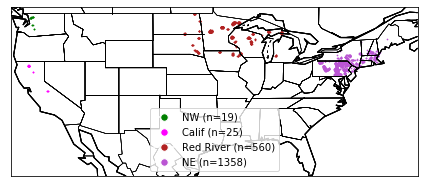

<Figure size 432x288 with 0 Axes>

In [ ]:
##case study plots

from matplotlib.lines import Line2D

g = nc.Dataset('/home/weltyj/Desktop/som_test/dswetimeyyyymmdd.nc','r')
dsweyyyymmdd = g.variables["dswetime"][:]
dswelats = g.variables["lat"][:]
dswelons = g.variables["lon"][:]
dswelon, dswelat = np.meshgrid(dswelons[:], dswelats[:])

fig, axs = plt.subplots(1, 1,tight_layout = True, sharex=True,sharey = True)
#fig.subtitle('R occurrence',fontweight='bold')

#fig.subplots_adjust(bottom=0.55,left=0.1,hspace=None,wspace=0.2)

#gs = gridspec.GridSpec(Nr, Nc, hspace=None,wspace=None)#width_ratios=[1, 1, 1])
#gs1 = gridspec.GridSpec(2, 3)
#gs1.update(wspace=0.025, hspace=0.0)

# Because our lon and lat variables are 1D,
# use meshgrid to create 2D arrays
# Not necessary if coordinates are already in 2D arrays.
lon, lat = np.meshgrid(lons[:], lats[:])

#np.squeeze(diurnallow[5,200,:,:])

images = []

vmin = np.nanmin(neurons)#min(image.get_array().min() for image in images)
vmax = np.nanmax(neurons)#max(image.get_array().max() for image in images)
if anom==1:
    clev = np.linspace(-200,200,11,endpoint=True)
    cmap = plt.get_cmap('PuOr_r')
else:
    clev = np.linspace(5200,5900,14,endpoint=False)
    cmap = plt.get_cmap('rainbow')
#clev = np.linspace(0,1e-4,10,endpoint=False)
#clev = np.linspace(0,15e-3,10,endpoint=False)
#clev = np.linspace(260,300,10,endpoint=False)
norm = BoundaryNorm(clev,ncolors=cmap.N,clip=True)

clevivt = np.linspace(0,250,11,endpoint=True)
normivt = BoundaryNorm(clevivt,ncolors=cmap.N,clip=True)

timevec = [[19961231,20170210],[19970403,19960120]]
timevec_1 = [[19961230,20170209],[19970402,19960119]]
timevec_2 = [[19961229,20170208],[19970401,19960118]]
timevec_3 = [[19961228,20170207],[19970331,19960117]]
timevec_4 = [[19961227,20170206],[19970330,19960116]]
timevec_5 = [[19961226,20170205],[19970329,19960115]]
timevec_6 = [[19961225,20170204],[19970328,19960114]]
colmat = [['green','magenta'],['firebrick','mediumorchid']]
latmin = [[42,32],[40,40]]
latmax = [[52,42],[50,50]]
lonmin = [[-125,-125],[-100,-80]]
lonmax = [[-118,-118],[-85,-65]]

for i in range(2):
    for j in range(2):
        print(latmin[i][j])
        print(latmax[i][j])
        print(lonmin[i][j])
        print(lonmax[i][j])
        m = Basemap(projection='cyl',llcrnrlat=25,urcrnrlat=50,\
            llcrnrlon=-125,urcrnrlon=-65,resolution='c',ax=axs)
        xi, yi = m(dswelon[((dsweyyyymmdd==timevec[i][j])|(dsweyyyymmdd==timevec_1[i][j])|\
                            (dsweyyyymmdd==timevec_2[i][j])|(dsweyyyymmdd==timevec_3[i][j])|\
                            (dsweyyyymmdd==timevec_4[i][j])|(dsweyyyymmdd==timevec_5[i][j])|\
                            (dsweyyyymmdd==timevec_6[i][j]))&(dswelon>=lonmin[i][j])&(dswelon\
                            <=lonmax[i][j])&(dswelat>=latmin[i][j])&(dswelat<=latmax[i][j])],\
                            dswelat[((dsweyyyymmdd==timevec[i][j])|(dsweyyyymmdd==timevec_1[i][j])|\
                            (dsweyyyymmdd==timevec_2[i][j])|(dsweyyyymmdd==timevec_3[i][j])|\
                            (dsweyyyymmdd==timevec_4[i][j])|(dsweyyyymmdd==timevec_5[i][j])|\
                            (dsweyyyymmdd==timevec_6[i][j]))&(dswelon>=lonmin[i][j])&\
                            (dswelon<=lonmax[i][j])&(dswelat>=latmin[i][j])&(dswelat<=latmax[i][j])])
        np.shape(xi)
        np.shape(yi)
        m.drawcoastlines()
        m.drawstates()
        m.drawcountries()
        print(np.shape(xi))
        print(np.shape(yi))
        images = m.scatter(xi,yi,marker=".",color=colmat[i][j],s=2)

        print(np.shape(dswelon[(dsweyyyymmdd==timevec[i][j])&(dswelon>=lonmin[i][j])&(dswelon\
                            <=lonmax[i][j])&(dswelat>=latmin[i][j])&(dswelat<=latmax[i][j])]))

#fig.subplots_adjust(right=0.7,hspace=0.4)


# Add Title
#plt.title('Merged IR '+startdate+' '+enddate)
legend_elements = [Line2D([0], [0], marker='.', color='white', label='NW (n=19)',
                          markerfacecolor='green', markersize=15),Line2D([0], \
                          [0], marker='.', color='white', label='Calif (n=25)',
                          markerfacecolor='magenta', markersize=15),\
                          Line2D([0],[0], marker='.', color='white', label='Red River (n=560)',
                          markerfacecolor='firebrick', markersize=15),Line2D([0], \
                          [0], marker='.', color='white', label='NE (n=1358)',
                          markerfacecolor='mediumorchid', markersize=15)]
plt.legend(handles=legend_elements,loc='lower center',bbox_to_anchor=(0.5,0.0))
plt.show()
plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.tight_layout(pad=0., w_pad=0., h_pad=0.)
fig.savefig('dswe_spatial_agg.pdf')

#axs[0].title.set_text('all')
#axs[1].title.set_text('L regime')
#axs[2].title.set_text('M regime')
#axs[3].title.set_text('H regime')
#plt.title('mean afternoon rain')

In [ ]:
print(h500shape[0])
print(h500_nw_shape[0])
print(h500_sierra_shape[0])
print(h500_rockies_shape[0])
print(h500_gl_shape[0])
print(h500_ne_shape[0])

1497
272
214
492
181
262


In [ ]:
print(np.sum(count_pred_ros_nor[0:6,:],axis=1))
print(np.sum(count_pred_ros_nor[6::,:],axis=1))

[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
